# 📘 Image Classification with CNN – Full Project Notebook

## 📦 3.1.1 – Data Understanding, Visualization, Cleaning

Mounted at /content/drive
Training set class distribution: {'Peach': 1242, 'Mango': 908, 'Cherry': 1262, 'Banana': 1432, 'Grape': 1498}
Test set class distribution: {}


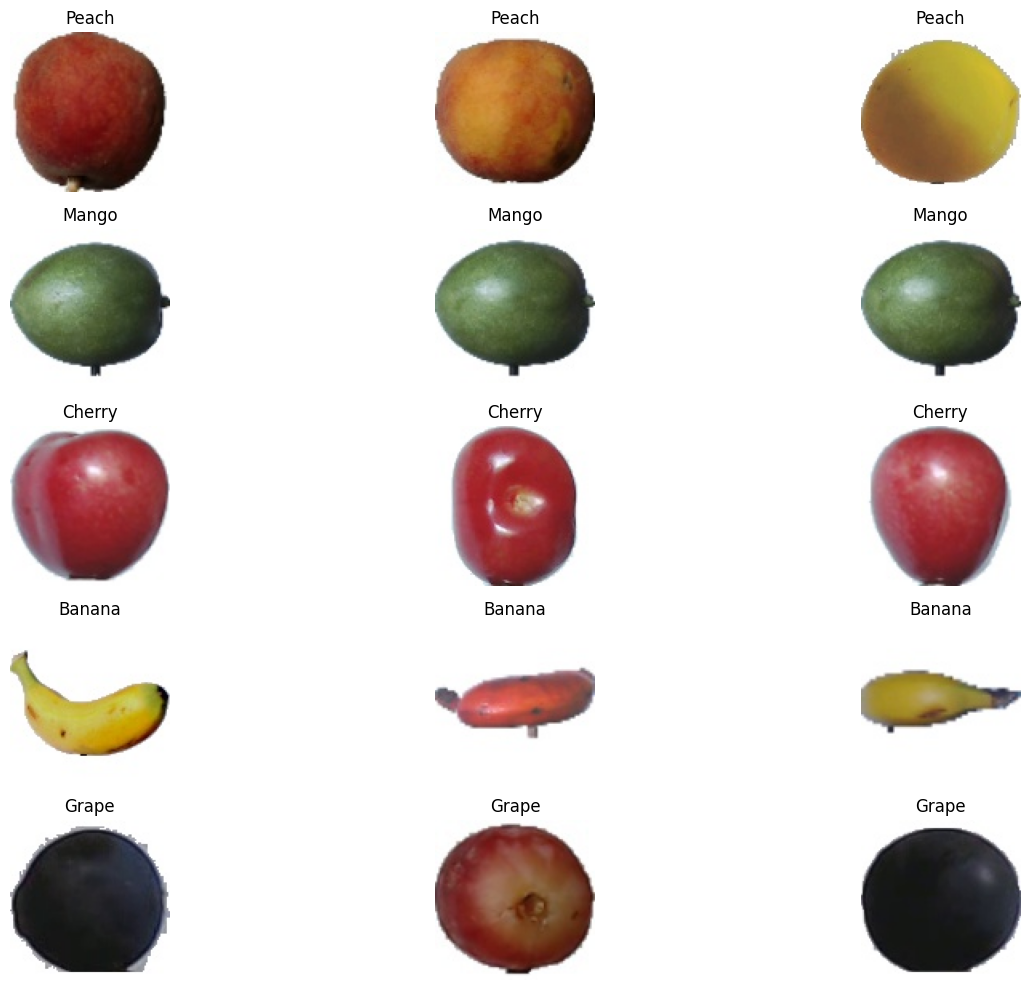

Found 5076 images belonging to 5 classes.
Found 1266 images belonging to 5 classes.
Found 0 images belonging to 0 classes.


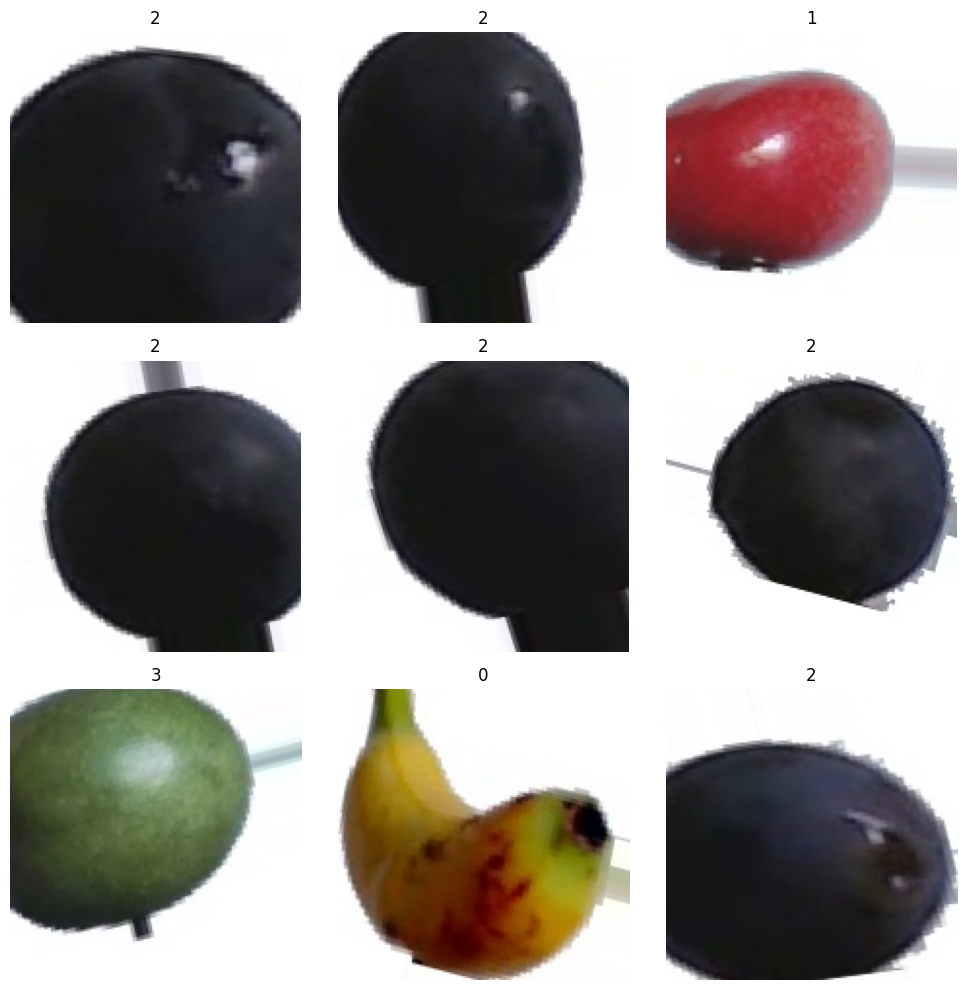

In [ ]:
# 📦 3.1.1 – Data Understanding, Analysis, Visualization and Cleaning

# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image, ImageFile
import warnings

ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Dataset paths (update accordingly)
train_dir = '/content/drive/MyDrive/Colab Notebooks/Fruits Dataset/Train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Fruits Dataset/Test'

# Check dataset structure
def check_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
    return class_counts

train_counts = check_class_distribution(train_dir)
test_counts = check_class_distribution(test_dir)

print("Training set class distribution:", train_counts)
print("Test set class distribution:", test_counts)

# Visualize sample images
def plot_sample_images(directory, n_samples=3):
    plt.figure(figsize=(15, 10))
    classes = os.listdir(directory)
    for idx, class_name in enumerate(classes[:5]):
        class_path = os.path.join(directory, class_name)
        images = os.listdir(class_path)[:n_samples]
        for i, img_file in enumerate(images):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            img = img.convert('RGB')
            plt.subplot(len(classes), n_samples, idx*n_samples + i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(train_dir)

# Clean dataset (remove corrupted files)
def clean_dataset(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(root, file)
                try:
                    img = Image.open(path)
                    img.verify()
                except:
                    os.remove(path)
                    print(f"Removed corrupt file: {path}")

clean_dataset(train_dir)
clean_dataset(test_dir)

# Data Generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

x, y = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x[i])
    plt.title(np.argmax(y[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()


## 📦 3.1.2 – Baseline CNN Model

In [ ]:
# Baseline CNN Model (3 Conv + Pool, 3 FCN)
baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,838,853 (18.46 MB)

 Trainable params: 4,838,853 (18.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 75s 431ms/step - accuracy: 0.6443 - loss: 0.9068 - val_accuracy: 0.9447 - val_loss: 0.1833
Epoch 2/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 55s 346ms/step - accuracy: 0.9793 - loss: 0.0696 - val_accuracy: 0.9566 - val_loss: 0.1293
Epoch 3/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 55s 348ms/step - accuracy: 0.9792 - loss: 0.0616 - val_accuracy: 0.9905 - val_loss: 0.0318
Epoch 4/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 67s 420ms/step - accuracy: 0.9938 - loss: 0.0273 - val_accuracy: 0.9842 - val_loss: 0.0653
Epoch 5/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.9910 - loss: 0.0310 - val_accuracy: 0.9629 - val_loss: 0.1063
Epoch 6/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 82s 354ms/step - accuracy: 0.9930 - loss: 0.0178 - val_accuracy: 0.9858 - val_loss: 0.0399
Epoch 7/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 55s 347ms/step - accuracy: 0.9960 - loss: 0.0118 - val_accuracy: 0.9953 - val_loss: 0.0168
Epoch 8/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 81s 342ms/step - accuracy: 0.9984 - loss: 0

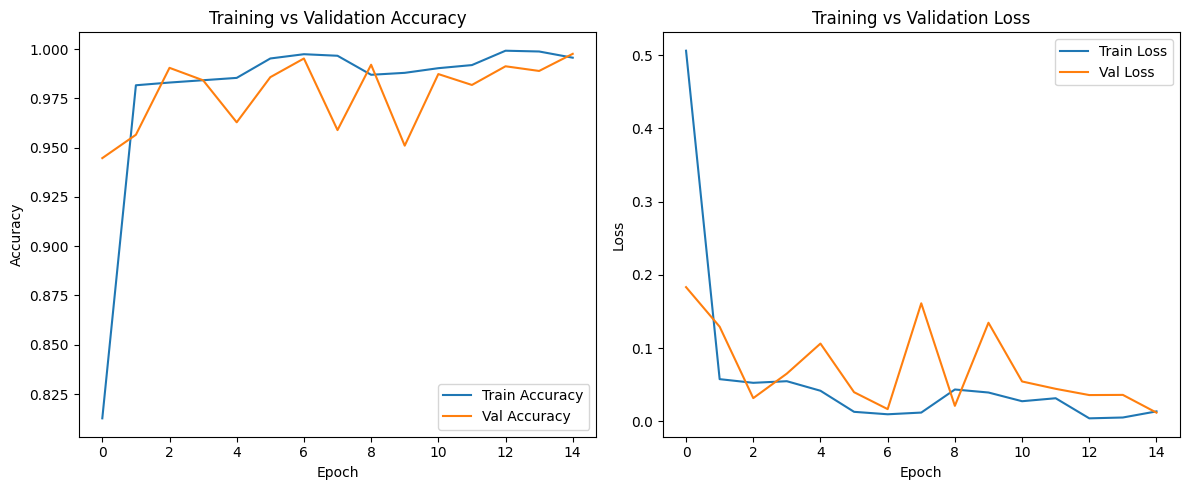

In [ ]:
# Train Baseline Model
history = baseline_model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


⚠️ 🚫 The dataset is empty. No images to evaluate.
🔁 Switching to fallback generator (validation set)...
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step

📊 Classification Report – Validation Set Evaluation
              precision    recall  f1-score   support

      Banana       0.22      0.21      0.21       286
      Cherry       0.21      0.21      0.21       252
       Grape       0.26      0.26      0.26       299
       Mango       0.12      0.12      0.12       181
       Peach       0.23      0.24      0.24       248

    accuracy                           0.21      1266
   macro avg       0.21      0.21      0.21      1266
weighted avg       0.21      0.21      0.21      1266



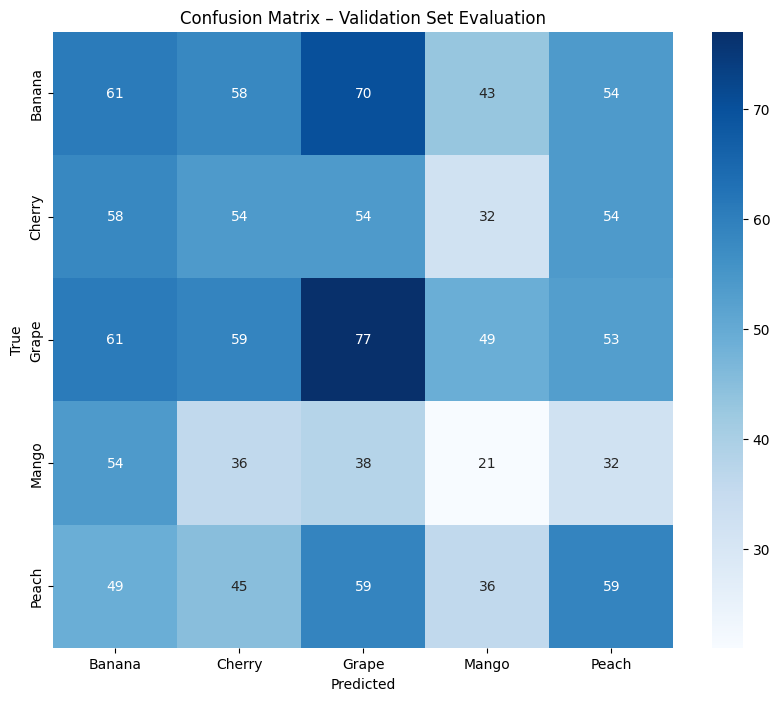

In [ ]:
# ✅ Safe Evaluation for Baseline Model

def safe_evaluate_model(model, generator, fallback_generator=None, title="Model Evaluation"):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, confusion_matrix

    try:
        if generator.samples == 0:
            raise ValueError("🚫 The dataset is empty. No images to evaluate.")

        # Predict and evaluate
        y_pred_probs = model.predict(generator)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = generator.classes
        class_labels = list(generator.class_indices.keys())

        # Classification report
        print(f"\n📊 Classification Report – {title}")
        print(classification_report(y_true, y_pred, target_names=class_labels))

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
        plt.title(f'Confusion Matrix – {title}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    except ValueError as e:
        print("⚠️", e)
        if fallback_generator:
            print("🔁 Switching to fallback generator (validation set)...")
            return safe_evaluate_model(model, fallback_generator, title="Validation Set Evaluation")
        else:
            print("❌ No fallback provided. Please check your test dataset structure.")

# 👉 Use this like:
safe_evaluate_model(baseline_model, test_generator, fallback_generator=val_generator, title="Baseline Model")


## 📦 3.1.3 – Deeper CNN Model with Regularization

In [ ]:
# Deeper CNN Architecture with Batch Normalization and Dropout
deeper_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

deeper_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

deeper_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,643,333 (13.90 MB)

 Trainable params: 3,642,373 (13.89 MB)

 Non-trainable params: 960 (3.75 KB)

⚠️ 🚫 The dataset is empty. No images to evaluate.
🔁 Using fallback validation set instead.
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step
📊 Classification Report – Validation Set Evaluation
              precision    recall  f1-score   support

      Banana       0.24      0.18      0.20       286
      Cherry       0.21      0.21      0.21       252
       Grape       0.25      0.25      0.25       299
       Mango       0.18      0.18      0.18       181
       Peach       0.20      0.25      0.22       248

    accuracy                           0.22      1266
   macro avg       0.21      0.21      0.21      1266
weighted avg       0.22      0.22      0.22      1266



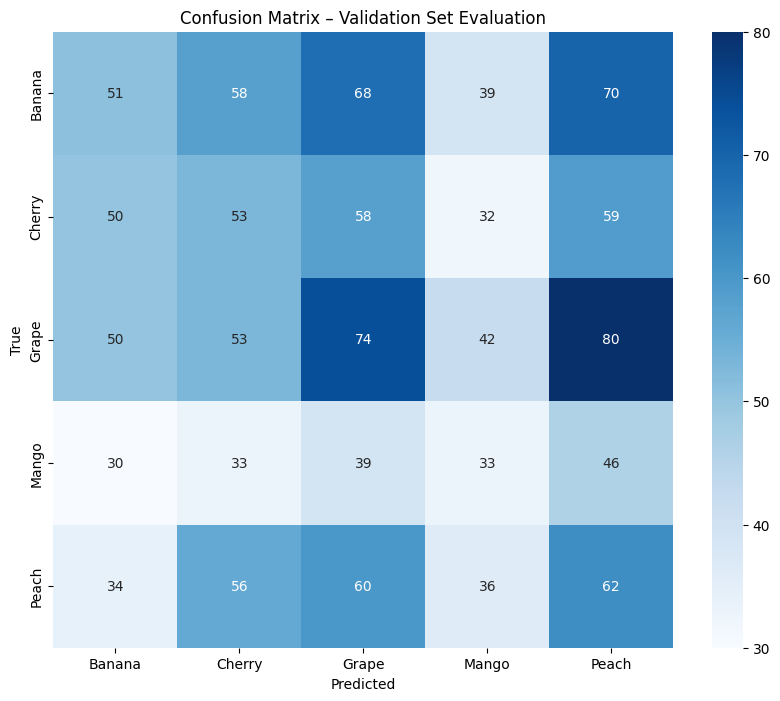

In [ ]:
def safe_evaluate_model(model, generator, fallback_generator=None, title="Model Evaluation"):
    try:
        if generator.samples == 0:
            raise ValueError("🚫 The dataset is empty. No images to evaluate.")

        y_pred_probs = model.predict(generator)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = generator.classes
        class_labels = list(generator.class_indices.keys())

        print(f"📊 Classification Report – {title}")
        print(classification_report(y_true, y_pred, target_names=class_labels))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
        plt.title(f'Confusion Matrix – {title}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    except ValueError as e:
        print("⚠️", e)
        if fallback_generator:
            print("🔁 Using fallback validation set instead.")
            return safe_evaluate_model(model, fallback_generator, title="Validation Set Evaluation")
        else:
            print("❌ No fallback available.")

# Call it like this:
safe_evaluate_model(deeper_model, test_generator, fallback_generator=val_generator, title="Deeper Model")


## 📦 3.1.4 – Optimizer Comparison: Adam vs SGD

Epoch 1/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 67s 388ms/step - accuracy: 0.6601 - loss: 1.0739 - val_accuracy: 0.7844 - val_loss: 0.6063
Epoch 2/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 58s 364ms/step - accuracy: 0.9134 - loss: 0.2679 - val_accuracy: 0.7480 - val_loss: 1.5459
Epoch 3/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 56s 350ms/step - accuracy: 0.9522 - loss: 0.1765 - val_accuracy: 0.6335 - val_loss: 2.3212
Epoch 4/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 55s 349ms/step - accuracy: 0.9624 - loss: 0.1328 - val_accuracy: 0.5742 - val_loss: 2.8324
Epoch 5/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 55s 348ms/step - accuracy: 0.9713 - loss: 0.1118 - val_accuracy: 0.9708 - val_loss: 0.1019
Epoch 6/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 55s 348ms/step - accuracy: 0.9695 - loss: 0.1057 - val_accuracy: 0.9779 - val_loss: 0.0699
Epoch 7/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 83s 357ms/step - accuracy: 0.9838 - loss: 0.0691 - val_accuracy: 0.9897 - val_loss: 0.0380
Epoch 8/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 56s 354ms/step - accuracy: 0.9696 - loss: 0

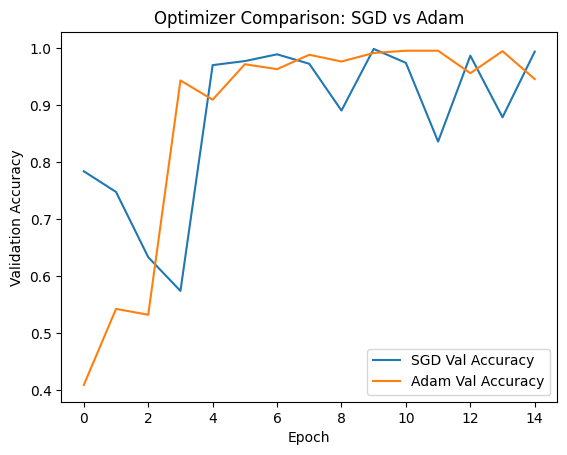

In [ ]:
# Optimizer Comparison: SGD vs Adam

# Compile with SGD
deeper_model_sgd = tf.keras.models.clone_model(deeper_model)
deeper_model_sgd.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with SGD
sgd_history = deeper_model_sgd.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

# Compare optimizer results
plt.plot(sgd_history.history['val_accuracy'], label='SGD Val Accuracy')
plt.plot(deep_history.history['val_accuracy'], label='Adam Val Accuracy')
plt.title("Optimizer Comparison: SGD vs Adam")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()


## 📦 Part B – Transfer Learning with VGG16

Found 5076 images belonging to 5 classes.
Found 1266 images belonging to 5 classes.
Found 0 images belonging to 0 classes.
Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.9119 - loss: 4.1686 - val_accuracy: 1.0000 - val_loss: 1.1299e-09
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 212ms/step - accuracy: 0.9963 - loss: 0.1007 - val_accuracy: 1.0000 - val_loss: 1.2137e-07
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.9904 - loss: 0.3455 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 212ms/step - accuracy: 0.9977 - loss: 0.0718 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.9984 - loss: 0.1545 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - accuracy: 0.9967 - loss: 0.1957 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 

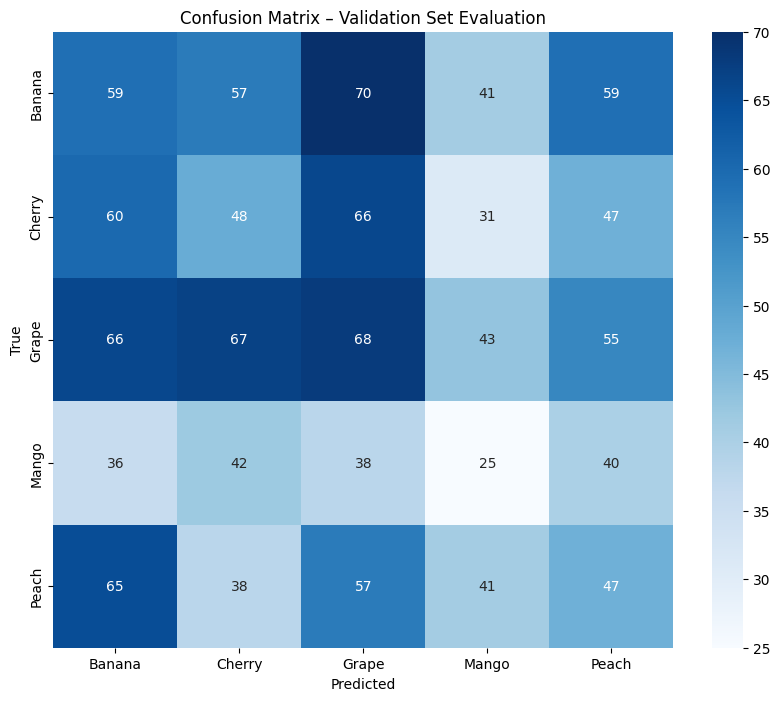

In [ ]:
# 📦 Transfer Learning with VGG16 and Safe Evaluation

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Data Generators
train_datagen_transfer = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator_transfer = train_datagen_transfer.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator_transfer = train_datagen_transfer.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ✅ Build the Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

transfer_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator_transfer.num_classes, activation='softmax')
])

transfer_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Train the Model
transfer_history = transfer_model.fit(
    train_generator_transfer,
    validation_data=val_generator_transfer,
    epochs=10
)

# ✅ Safe Evaluation Function
def safe_evaluate_model(model, generator, fallback_generator=None, title="Model Evaluation"):
    try:
        if generator.samples == 0:
            raise ValueError("🚫 The dataset is empty. No images to evaluate.")

        y_pred_probs = model.predict(generator)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = generator.classes
        class_labels = list(generator.class_indices.keys())

        print(f"📊 Classification Report – {title}")
        print(classification_report(y_true, y_pred, target_names=class_labels))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
        plt.title(f'Confusion Matrix – {title}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    except ValueError as e:
        print("⚠️", e)
        if fallback_generator:
            print("🔁 Using fallback validation set.")
            return safe_evaluate_model(model, fallback_generator, title="Validation Set Evaluation")
        else:
            print("❌ No fallback available. Check your test dataset.")

# 🧪 Run Evaluation
safe_evaluate_model(transfer_model, test_generator, fallback_generator=val_generator_transfer, title="Transfer Learning Evaluation")
